<p>Example script to extract 1 month of hourly MLST MSG product over a domain</p>

In [1]:
import datetime as dt
import thredds_lsasaf_utils as tlu
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import rasterio
from rasterio.mask import mask
from shapely.geometry import Point
from shapely import wkt

import statsmodels.api as sm
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.families.links import Power
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log, identity

import pickle


In [2]:
def download_data(dstart, dend, product_freq, LatLonBox):

    # Change here your user credentials
    server_user = "karpagam"
    server_passwd = "chip-chop-2025"

    # Change here the product details
    # Go to https://thredds.lsasvcs.ipma.pt/thredds/catalog/catalog.html
    # Navigate selecting satelite, product, format, and data to find the product_path and product file name
    # This is an example for the MSG MLST

    product_path = "/MSG/MLST/NETCDF/"
    product_fname = "NETCDF4_LSASAF_MSG_LST_MSG-Disk"
    NcvarsLoad = ['LST'] # list of netcdf variables to load from remote files

    # Initialize product details
    product = tlu.lsa_product(product_path,product_fname)
    product.user = server_user
    product.passwd = server_passwd

    # list of slots to be processed:
    slot_list = tlu.gen_slot_list(dstart, dend, product_freq)
    print(f"Will load:{len(slot_list)} files: {slot_list[0]} to {slot_list[-1]}")

    # Load data
    ds_full = tlu.load_product_slots_domain(product, slot_list, NcvarsLoad, LatLonBox=LatLonBox)

    # Extract the data array (assuming the variable name is 'temperature')
    data_array = ds_full['LST']

    # Step 1: Extract the temperature DataArray
    temperature_da = ds_full['LST']

    # Step 2: Stack dimensions (combine 'time', 'lat', and 'lon')
    stacked = temperature_da.stack(points=('time', 'lat', 'lon'))

    # Step 3: Reset the index and convert to DataFrame
    df = stacked.reset_index(['time', 'lat', 'lon']).to_dataframe(name='temperature').reset_index(drop=True)

    # Step 4: Add an 'hour' column 'day', 'month' and 'year'
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year

    # Create geometry from latitude and longitude
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Set the Coordinate Reference System (CRS) - assuming WGS84 (EPSG:4326)
    gdf.set_crs(epsg=4326, inplace=True)

    return gdf

In [ ]:
# Time period to process
dstart = dt.datetime(2023, 7, 1, 0, 0, 0) # start slot
dend = dt.datetime(2023, 8, 31, 23, 59, 59)   # end slot

# Frequency
product_freq = "h" # hourly frequency

# Define latitude/longitude domain to load [lat_min,lat_max,lon_min,lon_max,]
LatLonBox = [41.6899140207028722, 42.0902931428349447, 12.2299337725884012, 12.7300258912577391] # Rome

# Download data
gdf = download_data(dstart, dend, product_freq, LatLonBox)

# Drop the 'geometry' column
df_no_geometry = gdf.drop(columns=['geometry'])

# Create filename
csv_filename = f'LST_{dstart.year}-{dstart.month}-{dstart.day}_{dend.year}-{dend.month}-{dend.day}.csv'

# Save to a CSV file
df_no_geometry.to_csv(csv_filename, index=False)

print(f'GeoDataFrame without geometry saved as {csv_filename}')

In [25]:
def read_fused_data(filename):

    # Replace 'your_file.csv' with the path to your CSV file
    file_path = filename

    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Ensure the CSV contains 'lat' and 'lon' columns
    if 'lat' not in df.columns or 'lon' not in df.columns:
        raise ValueError("The CSV file must contain 'lat' and 'lon' columns")

    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Set the coordinate reference system (CRS) if known, e.g., WGS84 (EPSG:4326)
    gdf.set_crs(epsg=4326, inplace=True)

    return gdf

In [ ]:

# Load the pickle file
with open('landuse_profile.pkl', 'rb') as file:
    loaded_geo_lulc_dict = pickle.load(file)

print("Loaded landuse profile:", loaded_geo_lulc_dict)

# Create GeoDataFrame from dictionary
lulc_gdf = gpd.GeoDataFrame(
    list(loaded_geo_lulc_dict.items()),
    columns=['geometry', 'lulc_values'],
    geometry='geometry'
)
lulc_gdf.set_crs(gdf.crs, inplace=True)


In [27]:
sample_point = gdf['geometry'].iloc[0]
print("Sample GeoDataFrame Point:", sample_point)
print("Is this point in the dictionary?", sample_point in loaded_geo_lulc_dict)

Sample GeoDataFrame Point: POINT (12.25 42.05000305175781)
Is this point in the dictionary? True


In [28]:
# Round coordinates to a consistent precision (e.g., 6 decimal places)
def round_geometry(geom, precision=6):
    return Point(round(geom.x, precision), round(geom.y, precision))

# Update GeoDataFrame geometry
gdf['geometry'] = gdf['geometry'].apply(lambda geom: round_geometry(geom))

# Update LULC dictionary keys
loaded_geo_lulc_dict = {
    round_geometry(key): value for key, value in loaded_geo_lulc_dict.items()
}


In [29]:
# Map LULC values to the GeoDataFrame using the geometry column
gdf['lulc_values'] = gdf['geometry'].map(loaded_geo_lulc_dict)

# Display the updated GeoDataFrame
print(gdf.head())


        time        lat        lon  temperature  hour  day  month  year  \
0 2023-07-01  42.050003  12.250000        19.74     0    1      7  2023   
1 2023-07-01  42.050003  12.300003        19.16     0    1      7  2023   
2 2023-07-01  42.050003  12.349998        19.67     0    1      7  2023   
3 2023-07-01  42.050003  12.400002        18.48     0    1      7  2023   
4 2023-07-01  42.050003  12.450005          NaN     0    1      7  2023   

              geometry                                        lulc_values  
0  POINT (12.25 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...  
1   POINT (12.3 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...  
2  POINT (12.35 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...  
3   POINT (12.4 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...  
4  POINT (12.45 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...  


In [30]:

# Add the lulc columns from the pickle file to the geopandas dataframe, using the point geometry as the key
# Ensure geometry column matches the keys in the dictionary
# If the dictionary keys are WKT strings, convert them to geometry objects for comparison
# loaded_geo_lulc_dict = {Point(wkt.loads(k)): v for k, v in loaded_geo_lulc_dict.items()}

# Extract the LULC column names from the dictionary values (assuming uniform structure)
lulc_columns = [f'lulc_{i+1}' for i in range(len(next(iter(loaded_geo_lulc_dict.values()))))]

# Add LULC columns to GeoDataFrame
for idx, geom in enumerate(gdf['geometry']):
    lulc_values = loaded_geo_lulc_dict.get(geom, [None] * len(lulc_columns))
    for col, value in zip(lulc_columns, lulc_values):
        gdf.loc[idx, col] = value

# Display the updated GeoDataFrame
print(gdf.head())

        time        lat        lon  temperature  hour  day  month  year  \
0 2023-07-01  42.050003  12.250000        19.74     0    1      7  2023   
1 2023-07-01  42.050003  12.300003        19.16     0    1      7  2023   
2 2023-07-01  42.050003  12.349998        19.67     0    1      7  2023   
3 2023-07-01  42.050003  12.400002        18.48     0    1      7  2023   
4 2023-07-01  42.050003  12.450005          NaN     0    1      7  2023   

              geometry                                        lulc_values  \
0  POINT (12.25 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...   
1   POINT (12.3 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...   
2  POINT (12.35 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...   
3   POINT (12.4 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...   
4  POINT (12.45 42.05)  [0.0309770720283877, 0.1034086086277807, 7.261...   

     lulc_1    lulc_2        lulc_3    lulc_4    lulc_5    lulc_6    lulc_7  
0  0.030

In [31]:
# Convert geometry to WKT format
gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

# Save to CSV
output_csv_path = f'fused_{csv_filename}'
gdf.to_csv(output_csv_path, index=False)

print(f"GeoDataFrame saved to {output_csv_path}")


/tmp/ipykernel_125715/1670056041.py:2: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)


GeoDataFrame saved to fused_LST_2023-7-1_2023-8-31.csv


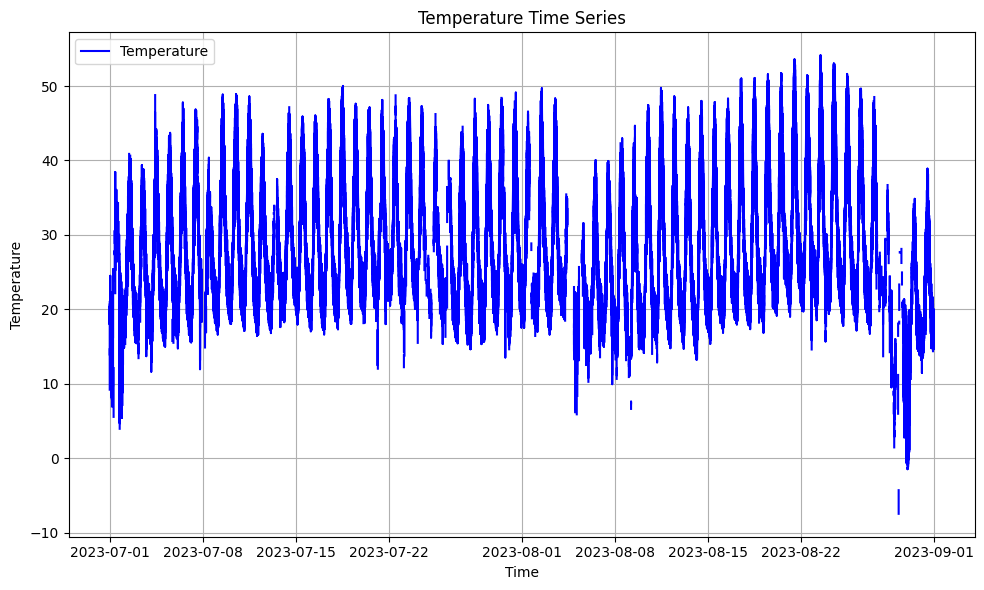

In [32]:
import matplotlib.pyplot as plt

# Ensure the 'time' column is in datetime format
gdf['time'] = pd.to_datetime(gdf['time'])

# Sort the GeoDataFrame by time for proper plotting
gdf = gdf.sort_values('time')

# Plot temperature over time
plt.figure(figsize=(10, 6))
plt.plot(gdf['time'], gdf['temperature'], label='Temperature', color='blue')

# Customize the plot
plt.title('Temperature Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()
